In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from tqdm import tqdm

In [4]:
df = pd.read_csv('/kaggle/input/imdb-movies-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# checking duplicated reviews / rows
df.duplicated().sum()

418

In [6]:
# removing duplicate reviews
df.drop_duplicates(inplace=True)

In [7]:
# encoding "Sentiment" feature
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['sentiment']= le.fit_transform(df['sentiment'])

In [8]:
le.classes_
# positive = 1
# negative = 0

array(['negative', 'positive'], dtype=object)

AxesSubplot(0.22375,0.11;0.5775x0.77)


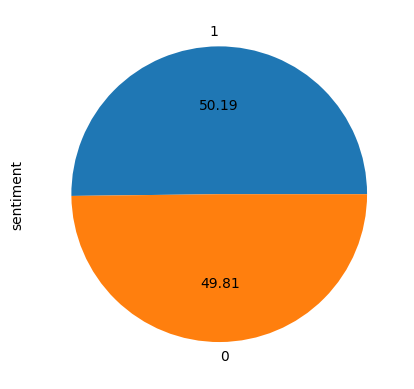

In [9]:
print(df['sentiment'].value_counts().plot(kind='pie',autopct="%.2f"))

# *DataSet is Balanced*

# **Text Preprocessing**

In [10]:
# lowerCasing the reviews
df['review'] = df['review'].str.lower()

In [11]:
# removing html tags
def rem_html_tgs(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'',text)

df['review'] = df['review'].apply(rem_html_tgs)

In [12]:
# removing punctuation marks
import string 
punc_marks = string.punctuation

def rem_punc(text):
    return text.translate(str.maketrans('', '', punc_marks))

df['review'] =df['review'].apply(rem_punc)

In [13]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1


In [14]:
# Performing Stemming 
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [15]:
def stemming(text):
    new_text = []
    
    for i in text.split():
        new_text.append(ps.stem(i))
    
    return " ".join(new_text)


tqdm.pandas()
df['review'] =df['review'].progress_apply(stemming)

100%|██████████| 49582/49582 [05:32<00:00, 149.23it/s]


In [16]:
# Removing stop Words
from nltk.corpus import stopwords
stp_wrds = stopwords.words('english')

def rmv_Stop(text):
    new_text = []
    for i in text.split():
        if i in stp_wrds:
            continue
        else:
            new_text.append(i)
    return " ".join(new_text)

tqdm.pandas()
df['review'] = df['review'].progress_apply(rmv_Stop)

100%|██████████| 49582/49582 [00:22<00:00, 2197.25it/s]


# Creating Corpus

In [17]:
import gensim
from gensim.utils import simple_preprocess

In [18]:
corpus = []
for i in tqdm(df['review']):
    # We have actually performed all necessary preprocessing 
    # we are perfoming simple_preprocess on each and every review just in case ...if something we have missed 
    corpus.append(simple_preprocess(i))

100%|██████████| 49582/49582 [00:15<00:00, 3221.71it/s]


# ***Text Vectorization***

In [19]:
# using Word2Vec Model 
model = gensim.models.Word2Vec(
    window=10,
    min_count=3
)

In [20]:
# building corpus 
model.build_vocab(corpus)

In [21]:
# finding out the default no. of epocs 
model.epochs

5

In [22]:
model.corpus_count

49582

In [23]:
# training the model
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

(28176360, 31461125)

In [24]:
model.wv.most_similar("thriller")

[('suspens', 0.7184441685676575),
 ('genr', 0.6678584218025208),
 ('giallo', 0.6432187557220459),
 ('thrill', 0.6420794725418091),
 ('drama', 0.638157308101654),
 ('yarn', 0.635326623916626),
 ('chiller', 0.6193220615386963),
 ('horrorthril', 0.6176242232322693),
 ('sentinel', 0.6174255013465881),
 ('noir', 0.6155142784118652)]

In [25]:
model.wv.doesnt_match(['thriller','crime','suspense','comedy'])

'comedy'

In [26]:
# no. of words in in the vocabulary
len(model.wv.index_to_key)

41523

# Saving the Word2Vec model for further use

In [90]:
import joblib
joblib.dump(model,'word2vec.joblib')

['word2vec.joblib']

In [27]:
# `document_vector` is a function that performs vectorization on a single document
def document_vector(doc):
    # the below line is remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    return np.mean(model.wv[doc], axis=0)

In [28]:
import tensorflow as tf

# Create an empty list to store the results
X = []

# Check if GPU is available
if tf.test.is_gpu_available():
    # Enable GPU usage
    with tf.device('/GPU:0'):
        # Iterate over the values in 'df['review'].values' using tqdm
        for i in tqdm(df['review'].values):
            # Perform document vectorization on GPU
            vector = document_vector(i)
            X.append(vector)
else:
    # Iterate over the values in 'df['review'].values' using tqdm
    for i in tqdm(df['review'].values):
        # Perform document vectorization
        vector = document_vector(i)
        X.append(vector)

100%|██████████| 49582/49582 [09:25<00:00, 87.67it/s] 


In [29]:
len(X[0])

100

# Creating Input and Output Feature i.e. X & Y

In [30]:
X = np.array(X)
Y = df.sentiment

In [31]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.15,stratify=Y)

## Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
lr = LogisticRegression(max_iter=1000)

In [39]:
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [40]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,lr.predict(X_test))

0.8670341489647755

## Decision Tree Classifier

In [64]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=None)

In [65]:
dtc.fit(X_train,y_train)

DecisionTreeClassifier()

In [66]:
accuracy_score(y_test,dtc.predict(X_test))

0.7499327776283947

## Random Forest Classifier

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
rfc = RandomForestClassifier()

In [69]:
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [70]:
accuracy_score(y_test,rfc.predict(X_test))

0.8465985479967734

## XGBoost Classifier

In [71]:
import xgboost as xgb

In [74]:
xgb_cls = xgb.XGBClassifier()

In [75]:
xgb_cls.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [76]:
accuracy_score(y_test,xgb_cls.predict(X_test))

0.8558752352783007

## SVC

In [32]:
from sklearn.svm import SVC

In [33]:
svc = SVC(C=3)
svc.fit(X_train,y_train)

SVC(C=3)

In [36]:
accuracy_score(y_test,svc.predict(X_test)) * 100

87.52352783006184

In [81]:
import joblib 
joblib.dump(svc,'model.joblib')

['model.joblib']